In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

In [151]:
IN_DATA_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/dafx_latent_extraction"
OUT_DATA_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/embedding_classifier"

In [25]:
emb = np.load(f"{IN_DATA_DIR}/emb_data.npy")
pca = np.load(f"{IN_DATA_DIR}/pca_features.npy")
labels = np.load(f"{IN_DATA_DIR}/labels.npy")

In [117]:
with open(f'{IN_DATA_DIR}/label_mapping.pkl', 'rb') as handle:
    m = pickle.load(handle)

In [120]:
dafx_name_format = {
     'mda Ambience': 'Ambience',
     'mda Combo': 'Combo',
     'mda Delay': 'Delay',
     'mda Dynamics': 'Dynamics',
     'mda Overdrive': 'Overdrive',
     'mda RingMod': 'RingMod',
}

In [123]:
mapping = {v: dafx_name_format[k] for k, v in m.items()}

In [124]:
mapping

{0: 'Ambience',
 1: 'Combo',
 2: 'Delay',
 3: 'Dynamics',
 4: 'Overdrive',
 5: 'RingMod'}

In [27]:
print("Model embedding shape: ", emb.shape)
print("PCA embedding shape: ", pca.shape)
print("Label shape:", labels.shape)

Model embedding shape:  (6000, 128)
PCA embedding shape:  (6000, 128)
Label shape: (6000,)


In [31]:
X_emb = pd.DataFrame(emb)
X_pca = pd.DataFrame(pca)
y = pd.Series(labels)

In [59]:
X_emb_train, X_emb_test, y_train, y_test = train_test_split(X_emb, y, test_size=.15)

In [60]:
X_pca_train = X_pca.iloc[X_emb_train.index]
X_pca_test = X_pca.iloc[X_emb_test.index]

In [61]:
print(f"Train size: {len(X_pca_train)}")
print(f"Test size: {len(X_pca_test)}")

Train size: 5100
Test size: 900


In [91]:
model_emb = RandomForestClassifier()
model_pca = RandomForestClassifier()

In [92]:
model_emb.fit(X_emb_train, y_train)

RandomForestClassifier()

In [93]:
model_pca.fit(X_pca_train, y_train)

RandomForestClassifier()

In [94]:
y_emb_hat = model_emb.predict(X_emb_test)

In [95]:
y_pca_hat = model_emb.predict(X_pca_test)

In [109]:
cm_emb = confusion_matrix(y_test, y_emb_hat, normalize='true')
cm_pca = confusion_matrix(y_test, y_pca_hat, normalize='true')

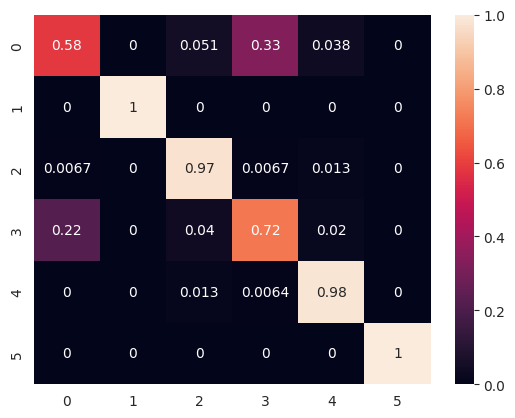

In [110]:
sns.heatmap(cm_emb, annot=True)
plt.show()

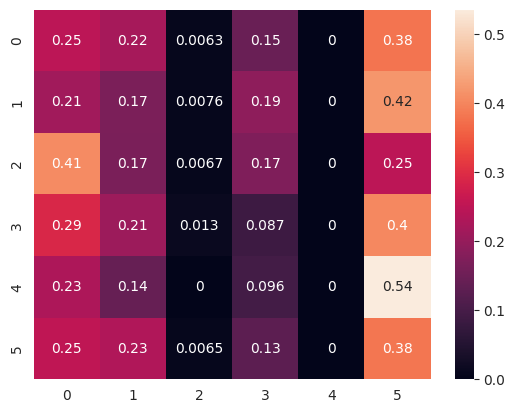

In [111]:
sns.heatmap(cm_pca, annot=True)
plt.show()

In [143]:
def sub_df_from_metrics(emb_type, y, y_hat, label_mapping):
    f1 = f1_score(y, y_hat, average=None).T
    cm = confusion_matrix(y, y_hat)
    acc = cm.diagonal()/cm.sum(axis=1).T
    fx_labels = np.array([label_mapping[i] for i in range(len(label_mapping))]).T

    df = pd.DataFrame({'DAFX': fx_labels, 'Acc': acc, 'F1': f1})
    df = df.set_index('DAFX')
    df.columns = pd.MultiIndex.from_product([[emb_type], df.columns])

    return df

In [146]:
emb_metrics_df = sub_df_from_metrics('Our model', y_test, y_emb_hat, mapping)

In [147]:
pca_metrics_df = sub_df_from_metrics('PCA', y_test, y_pca_hat, mapping)

In [149]:
metrics_df = pd.concat([emb_metrics_df, pca_metrics_df], axis=1)

In [152]:
metrics_df.to_csv(f"{OUT_DATA_DIR}/classifier_metrics.csv")

In [154]:
metrics_df

Our model                 PCA          
                Acc        F1       Acc        F1
DAFX                                             
Ambience   0.582278  0.647887  0.246835  0.193069
Combo      1.000000  1.000000  0.167939  0.145695
Delay      0.973333  0.935897  0.006667  0.012821
Dynamics   0.718121  0.690323  0.087248  0.095941
Overdrive  0.980892  0.956522  0.000000  0.000000
RingMod    1.000000  1.000000  0.380645  0.231373

In [163]:
blue_cm = sns.light_palette("blue", as_cmap=True)

styler = metrics_df.style\
        .background_gradient(cmap=blue_cm, vmin=0, vmax=1)\
        .set_properties(**{'text-align': 'center',
                           'font-family': "Calibri",})\
        .format(na_rep='', precision=2)

In [164]:
styler

In [165]:
styler.to_excel(f"{OUT_DATA_DIR}/metrics.xlsx")